<a href="https://colab.research.google.com/github/micah-shull/LLMs/blob/main/LLM_034_fine_tuning_yahoo_answers_script_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Yahoo Answers Topics Dataset Summary

The **Yahoo Answers Topics** dataset is a large-scale text classification dataset sourced from the Yahoo Answers community question-answering platform. It includes a diverse range of topics, making it a valuable resource for training and evaluating models on multiclass text classification tasks. The dataset is structured to classify user-submitted questions and answers into one of ten distinct topic categories.

#### Dataset Structure

- **Number of Classes**: 10
- **Classes**:
  1. Society & Culture
  2. Science & Mathematics
  3. Health
  4. Education & Reference
  5. Computers & Internet
  6. Sports
  7. Business & Finance
  8. Entertainment & Music
  9. Family & Relationships
  10. Politics & Government

- **Columns**:
  - **id**: Unique identifier for each entry.
  - **topic**: The target label, represented as an integer from 0 to 9, corresponding to one of the 10 topics above.
  - **question_title**: The title of the user’s question.
  - **question_content**: The full content of the question.
  - **best_answer**: The best answer selected for the question, if available.

- **Data Splits**:
  - **Training Set**: 1,400,000 samples
  - **Test Set**: 60,000 samples

#### Use Case

This dataset is ideal for exploring multiclass classification, particularly for tasks requiring a model to distinguish between broad thematic categories based on limited context. It is commonly used in research and applications involving topic classification, question answering, and content categorization.

#### Example Usage

The Yahoo Answers Topics dataset can be used to train models that automatically classify questions into general topics, which is helpful for content filtering, recommendation systems, and automated helpdesk systems.



#### Load & Import Libraries

In [2]:
# !pip install transformers datasets
# !pip install python-dotenv

In [3]:
# Hugging Face Libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Standard Libraries
import pandas as pd
import numpy as np
import os
import time
import json
from dotenv import load_dotenv

# Metrics and Evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [10]:
from huggingface_hub import login

# Load environment variables
load_dotenv('/content/API_KEYS.env')
huggingface_api_key = os.getenv("HUGGINGFACE_API_KEY")
# Log in using the Hugging Face API key
login(token=huggingface_api_key)
# os.environ["HF_TOKEN"] = hugginface_api_key
# print("HUGGINFACE API Key loaded from .env:",os.environ["HF_TOKEN"][0:10])

# Load the Yahoo Answers dataset
dataset = load_dataset("yahoo_answers_topics")

# Define the label names
label_names = [
    "Society & Culture", "Science & Mathematics", "Health", "Education & Reference",
    "Computers & Internet", "Sports", "Business & Finance", "Entertainment & Music",
    "Family & Relationships", "Politics & Government"
]

# Print the original dataset sizes
print("Original dataset sizes:")
print("Train:", len(dataset["train"]))
print("Test:", len(dataset["test"]))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Original dataset sizes:
Train: 1400000
Test: 60000


### Visualize Data Distributions

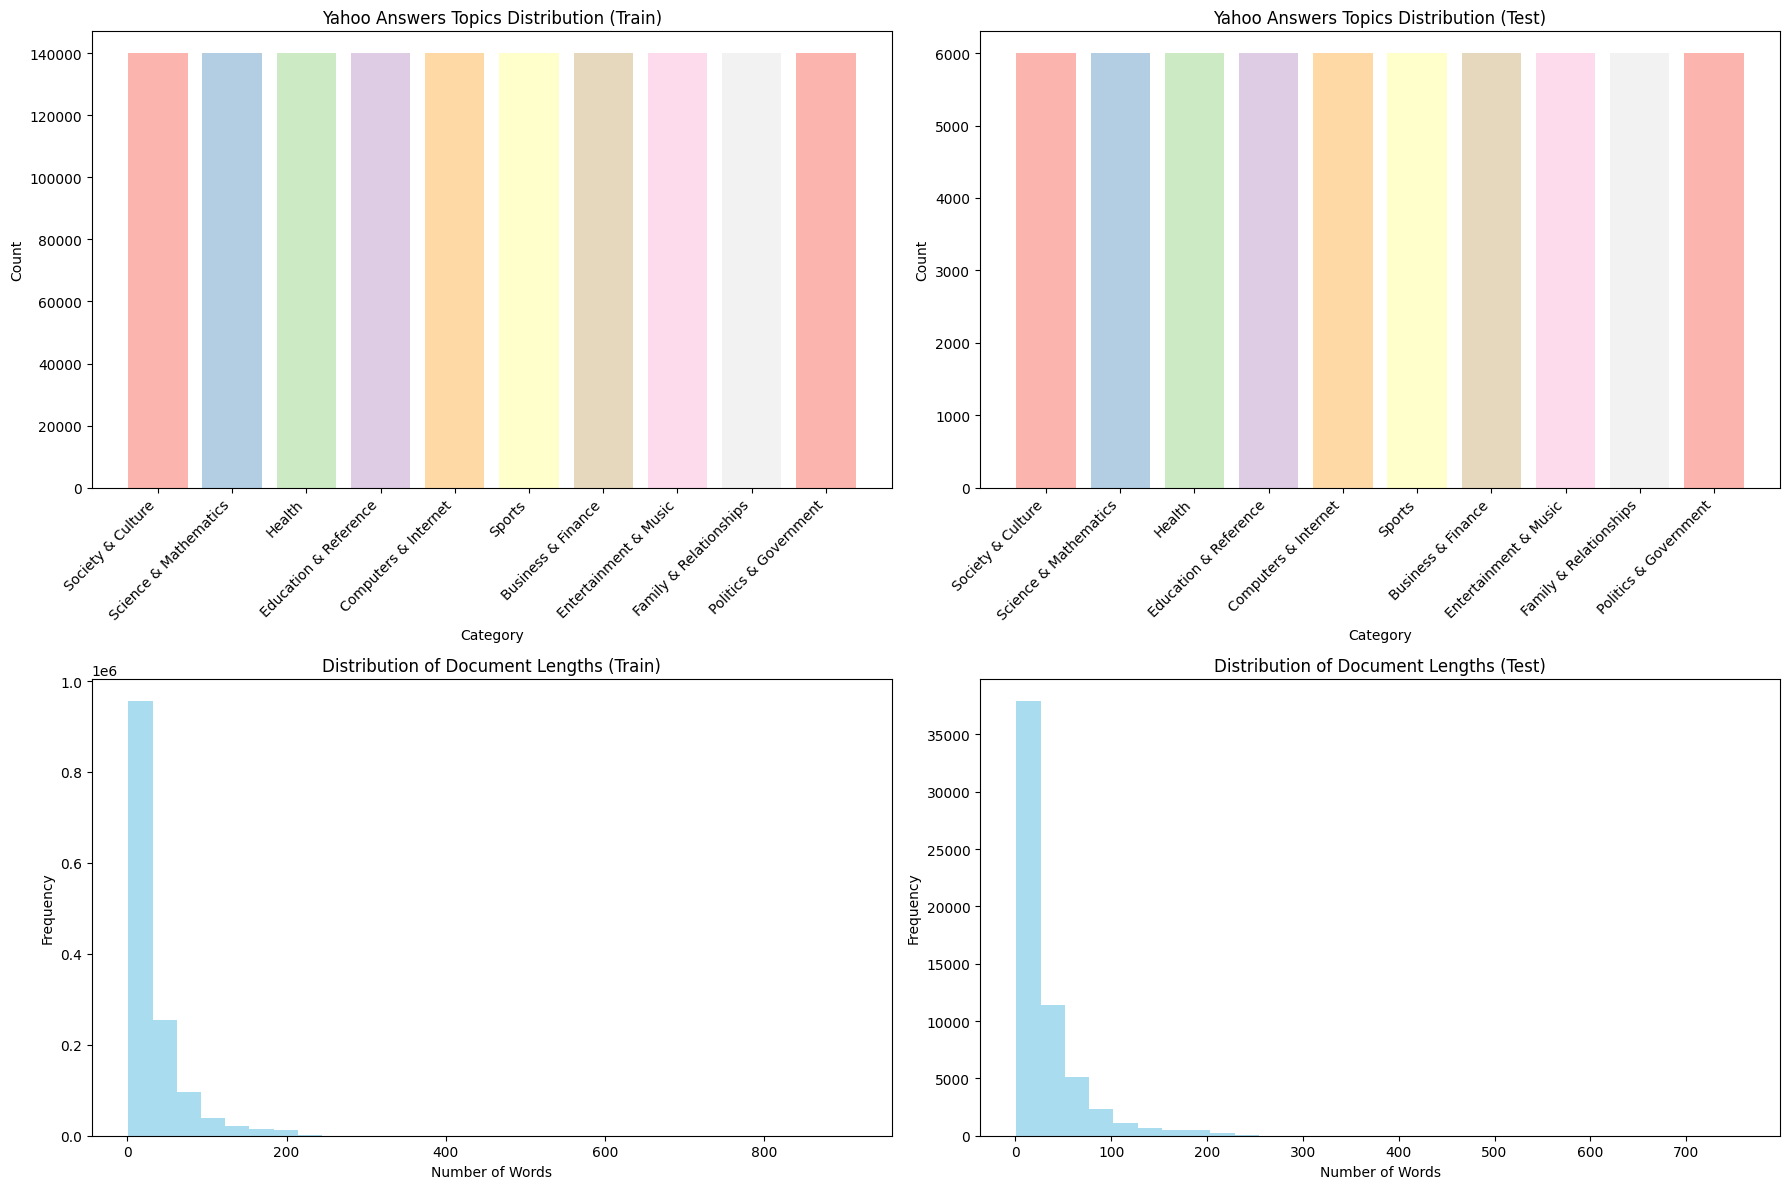

In [8]:
# Calculate value counts for labels for train and test datasets
train_label_counts = pd.Series(dataset['train']['topic']).value_counts().sort_index()
test_label_counts = pd.Series(dataset['test']['topic']).value_counts().sort_index()
train_label_counts.index = label_names  # Map numeric labels to topic names
test_label_counts.index = label_names   # Map numeric labels to topic names

# Combine 'question_title' and 'question_content' for document lengths for train and test datasets
train_documents = [f"{title} {content}" for title, content in zip(dataset['train']['question_title'], dataset['train']['question_content'])]
test_documents = [f"{title} {content}" for title, content in zip(dataset['test']['question_title'], dataset['test']['question_content'])]
train_document_lengths = [len(doc.split()) for doc in train_documents]  # Calculate document lengths for train
test_document_lengths = [len(doc.split()) for doc in test_documents]    # Calculate document lengths for test

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Set up a color palette
palette = sns.color_palette("Pastel1", 10)

# Plot 1: Train Label Distribution
axes[0, 0].bar(train_label_counts.index, train_label_counts.values, color=palette)
axes[0, 0].set_title("Yahoo Answers Topics Distribution (Train)")
axes[0, 0].set_xlabel("Category")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xticks(range(len(train_label_counts.index)))
axes[0, 0].set_xticklabels(train_label_counts.index, rotation=45, ha='right')

# Plot 2: Test Label Distribution
axes[0, 1].bar(test_label_counts.index, test_label_counts.values, color=palette)
axes[0, 1].set_title("Yahoo Answers Topics Distribution (Test)")
axes[0, 1].set_xlabel("Category")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xticks(range(len(test_label_counts.index)))
axes[0, 1].set_xticklabels(test_label_counts.index, rotation=45, ha='right')

# Plot 3: Train Document Length Distribution
axes[1, 0].hist(train_document_lengths, bins=30, color='skyblue', alpha=0.7)
axes[1, 0].set_title("Distribution of Document Lengths (Train)")
axes[1, 0].set_xlabel("Number of Words")
axes[1, 0].set_ylabel("Frequency")

# Plot 4: Test Document Length Distribution
axes[1, 1].hist(test_document_lengths, bins=30, color='skyblue', alpha=0.7)
axes[1, 1].set_title("Distribution of Document Lengths (Test)")
axes[1, 1].set_xlabel("Number of Words")
axes[1, 1].set_ylabel("Frequency")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Display basic statistics for train and test document lengths
print("Train Document Length Statistics:")
print("Mean Length:", sum(train_document_lengths) / len(train_document_lengths))
print("Max Length:", max(train_document_lengths))
print("Min Length:", min(train_document_lengths))
print("\nTest Document Length Statistics:")
print("Mean Length:", sum(test_document_lengths) / len(test_document_lengths))
print("Max Length:", max(test_document_lengths))
print("Min Length:", min(test_document_lengths))


## Sample Data

In [11]:
# Sample 10% of the original train and test datasets
sampled_train = dataset["train"].train_test_split(test_size=0.1, seed=42)["test"]  # Keep 10% of the training set
sampled_test = dataset["test"].train_test_split(test_size=0.1, seed=42)["test"]    # Keep 10% of the test set

# Print the sampled dataset sizes
print("\nSampled dataset sizes (10% of original sets):")
print("Sampled Train:", len(sampled_train))
print("Sampled Test:", len(sampled_test))

# Display the first few entries in the sampled datasets
for i in range(3):
    print(f"\nSample {i+1}:")
    print("Question Title:", sampled_train["question_title"][i])
    print("Question Content:", sampled_train["question_content"][i])
    print("Best Answer:", sampled_train["best_answer"][i])
    print("Label:", label_names[sampled_train["topic"][i]])
    print("=" * 50)

# Print the first entry of the sampled train and test datasets to inspect their structure
print("\nSampled Train Entry:")
print(json.dumps(sampled_train[0], indent=2))

print("\nSampled Test Entry:")
print(json.dumps(sampled_test[0], indent=2))



Sampled dataset sizes (10% of original sets):
Sampled Train: 140000
Sampled Test: 6000

Sample 1:
Question Title: My husband's brother was killed at sea in WWII. How do we find out the name of the ship?
Question Content: We have searched and cannot find a ship that sunk in the Pacific on or near the date of his death. He would have been on a troup carrier with the 43rd infantry.
Best Answer: Got an easier way for you to get the records. Since your husband is immediate family, you can now receive those records through the National Personnel Records Center in St. Louis. I have linked thier web site below wich includes instructions on how to apply.
Label: Politics & Government

Sample 2:
Question Title: Why Do So Many People Have a High Opinion of Ex-President Adulterer Bill Clinton?
Question Content: Bill Clinton was an adulterer. He undermined our copyright laws until 2019.
Best Answer: The economy was up, our soldiers weren't out there creating terrorists, other countries respected us

### Visualize Class Distribution after Sampling

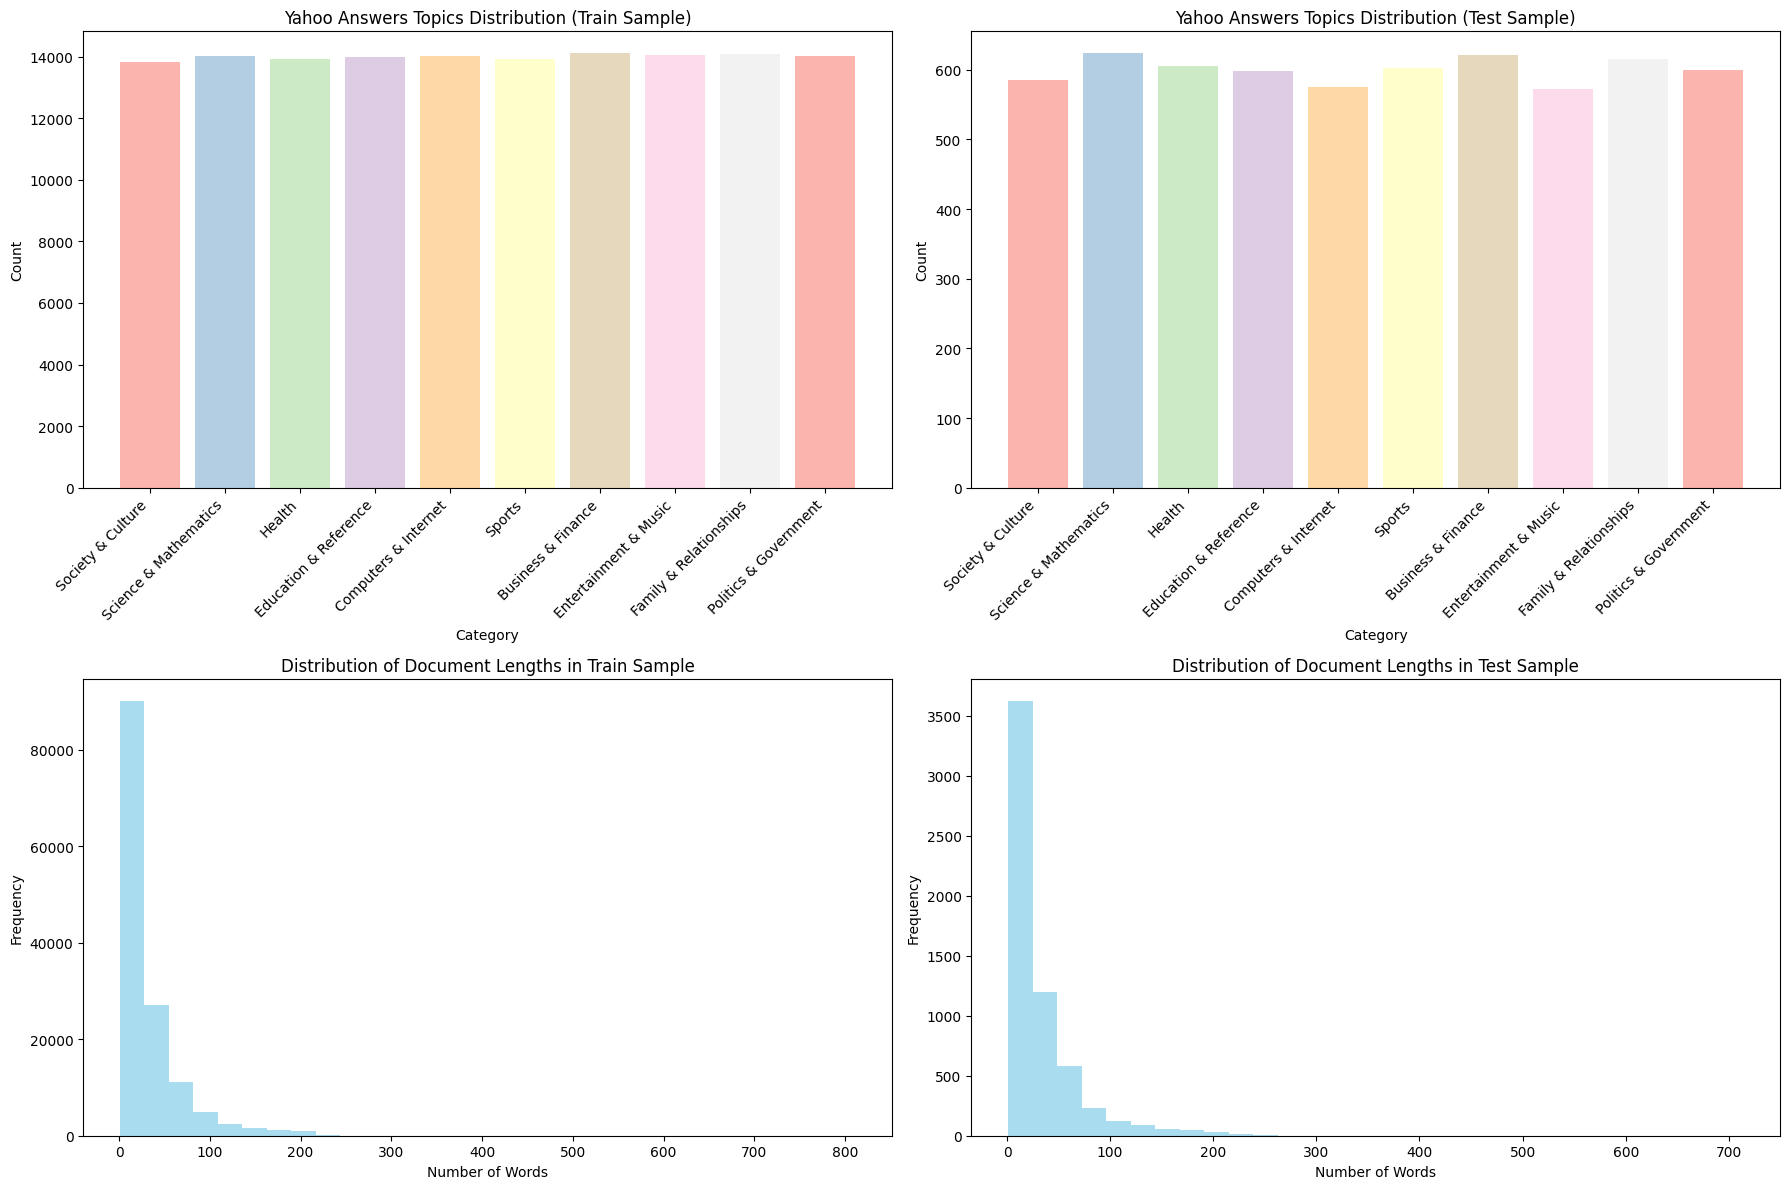

In [14]:
# Calculate value counts for labels in sampled train and test datasets
train_label_counts = pd.Series(train_sample['topic']).value_counts().sort_index()
test_label_counts = pd.Series(test_sample['topic']).value_counts().sort_index()
train_label_counts.index = label_names  # Map numeric labels to topic names
test_label_counts.index = label_names   # Map numeric labels to topic names

# Combine 'question_title' and 'question_content' for document lengths in sampled train and test datasets
train_documents = [f"{title} {content}" for title, content in zip(train_sample['question_title'], train_sample['question_content'])]
test_documents = [f"{title} {content}" for title, content in zip(test_sample['question_title'], test_sample['question_content'])]
train_document_lengths = [len(doc.split()) for doc in train_documents]  # Calculate document lengths for train sample
test_document_lengths = [len(doc.split()) for doc in test_documents]    # Calculate document lengths for test sample

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Set up a color palette
palette = sns.color_palette("Pastel1", 10)

# Plot 1: Train Label Distribution
axes[0, 0].bar(train_label_counts.index, train_label_counts.values, color=palette)
axes[0, 0].set_title("Yahoo Answers Topics Distribution (Train Sample)")
axes[0, 0].set_xlabel("Category")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xticks(range(len(train_label_counts.index)))
axes[0, 0].set_xticklabels(train_label_counts.index, rotation=45, ha='right')

# Plot 2: Test Label Distribution
axes[0, 1].bar(test_label_counts.index, test_label_counts.values, color=palette)
axes[0, 1].set_title("Yahoo Answers Topics Distribution (Test Sample)")
axes[0, 1].set_xlabel("Category")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xticks(range(len(test_label_counts.index)))
axes[0, 1].set_xticklabels(test_label_counts.index, rotation=45, ha='right')

# Plot 3: Train Document Length Distribution
axes[1, 0].hist(train_document_lengths, bins=30, color='skyblue', alpha=0.7)
axes[1, 0].set_title("Distribution of Document Lengths in Train Sample")
axes[1, 0].set_xlabel("Number of Words")
axes[1, 0].set_ylabel("Frequency")

# Plot 4: Test Document Length Distribution
axes[1, 1].hist(test_document_lengths, bins=30, color='skyblue', alpha=0.7)
axes[1, 1].set_title("Distribution of Document Lengths in Test Sample")
axes[1, 1].set_xlabel("Number of Words")
axes[1, 1].set_ylabel("Frequency")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


## Format Sampled Data

In [26]:
# Define a function to format the data for DistilBERT fine-tuning
def format_for_fine_tuning(dataset_sample):
    formatted_data = []

    for i in range(len(dataset_sample)):
        # Extract fields from the dataset
        question_title = dataset_sample[i].get('question_title', '')
        question_content = dataset_sample[i].get('question_content', '')
        label = dataset_sample[i].get('topic', None)  # Include the class label

        # Combine question title and content into a single string
        question = f"{question_title} {question_content}".strip()

        # Append formatted data
        formatted_data.append({
            "text": question,  # Use a single string input
            "label": label     # Add the class label
        })

    return formatted_data

# Format train and test datasets separately
formatted_train_data = format_for_fine_tuning(sampled_train)
formatted_test_data = format_for_fine_tuning(sampled_test)

# Print a sample formatted entry from train and test data to inspect the structure
print("Train Sample Entry:")
print(json.dumps(formatted_train_data[0], indent=2))

print("\nTest Sample Entry:")
print(json.dumps(formatted_test_data[0], indent=2))

# Save the formatted data to JSONL files
def save_to_jsonl(data, filename):
    with open(filename, 'w') as f:
        for entry in data:
            f.write(json.dumps(entry) + '\n')

# Save train and test data separately
save_to_jsonl(formatted_train_data, "formatted_yahoo_answers_train.jsonl")
save_to_jsonl(formatted_test_data, "formatted_yahoo_answers_test.jsonl")


Train Sample Entry:
{
  "text": "My husband's brother was killed at sea in WWII. How do we find out the name of the ship? We have searched and cannot find a ship that sunk in the Pacific on or near the date of his death. He would have been on a troup carrier with the 43rd infantry.",
  "label": 9
}

Test Sample Entry:
{
  "text": "Is the registered version of  REGISTRY MECHANIC worth paying for? Or is  the free version good enough?",
  "label": 4
}


In [27]:
# Print the first five entries of the formatted train data
print("First 5 entries of formatted train data:")
for i in range(5):
    print(formatted_train_data[i])

# Print the first five entries of the formatted test data
print("\nFirst 5 entries of formatted test data:")
for i in range(5):
    print(formatted_test_data[i])


First 5 entries of formatted train data:
{'text': "My husband's brother was killed at sea in WWII. How do we find out the name of the ship? We have searched and cannot find a ship that sunk in the Pacific on or near the date of his death. He would have been on a troup carrier with the 43rd infantry.", 'label': 9}
{'text': 'Why Do So Many People Have a High Opinion of Ex-President Adulterer Bill Clinton? Bill Clinton was an adulterer. He undermined our copyright laws until 2019.', 'label': 9}
{'text': 'Did Jesus have a rational mind?', 'label': 0}
{'text': 'Is there a way in MS Excel to have a cell be equal to multiple cells? e.g.= D3 and D5, where d3 & 5 are words? I\'m trying to make a cell that has a list of other cells.  e.g. I want my cell to say "[d4\'s value], [d5\'s value]"\\n\\nCan I do that?  Right now when I try, Excel spits out the "#value" error.  Can you help?', 'label': 4}
{'text': 'What is the purpose of Bayesian Inference? Hi. I know how Bayesian Statistical inference w

## Tokenize the Data

In [29]:
from transformers import AutoTokenizer

# Load the tokenizer for DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_data(entry):
    # Extract user text and class label
    user_text = entry["text"]  # Input text
    label = entry["label"]     # Scalar class label

    # Tokenize the input text
    tokenized_output = tokenizer(
        user_text,
        padding="max_length",
        truncation=True,
        max_length=128
    )

    # Add the scalar label directly
    tokenized_output["labels"] = label

    return {key: value for key, value in tokenized_output.items()}

# Save tokenized data to JSONL
def save_tokenized_data(tokenized_data, filepath):
    with open(filepath, "w") as f:
        for entry in tokenized_data:
            f.write(json.dumps(entry) + "\n")

# Tokenize and save train data
tokenized_train_data = [tokenize_data(entry) for entry in formatted_train_data]
save_tokenized_data(tokenized_train_data, "/content/tokenized_yahoo_answers_train.jsonl")

# Tokenize and save test data
tokenized_test_data = [tokenize_data(entry) for entry in formatted_test_data]
save_tokenized_data(tokenized_test_data, "/content/tokenized_yahoo_answers_test.jsonl")

# Print the first tokenized train data entry to verify
print("First tokenized train data entry:")
print(tokenized_train_data[0])

print("First tokenized test data entry:")
print(tokenized_test_data[0])

# Check the structure of the data
print("Training Dataset Sample:\n", pd.DataFrame(tokenized_train_data).head(10))
print("\nTest Dataset Sample:\n", pd.DataFrame(tokenized_test_data).head(10))


First tokenized train data entry:
{'input_ids': [101, 2026, 3129, 1005, 1055, 2567, 2001, 2730, 2012, 2712, 1999, 25755, 1012, 2129, 2079, 2057, 2424, 2041, 1996, 2171, 1997, 1996, 2911, 1029, 2057, 2031, 9022, 1998, 3685, 2424, 1037, 2911, 2008, 10417, 1999, 1996, 3534, 2006, 2030, 2379, 1996, 3058, 1997, 2010, 2331, 1012, 2002, 2052, 2031, 2042, 2006, 1037, 19817, 7140, 2361, 6839, 2007, 1996, 25747, 3939, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Convert to a Hugging Face Dataset

1. **Compatibility with Hugging Face Trainer**: Hugging Face's `Trainer` class expects the training and evaluation data to be in the form of a `Dataset` (from the `datasets` library). This format allows seamless integration with the `Trainer` API, making it straightforward to define and run training, evaluation, and even tokenized data manipulation.

2. **Efficiency and Scalability**: Hugging Face's `Dataset` object is optimized for large-scale datasets, enabling efficient handling of in-memory and memory-mapped data. It’s designed to handle transformations, batching, shuffling, and slicing efficiently, especially when working with large volumes of tokenized data.

3. **Preprocessing Flexibility**: The `Dataset` object provides easy methods for on-the-fly transformations, such as tokenization or data augmentation. It’s very flexible, allowing you to apply these transformations directly to each entry while maintaining an efficient workflow.

4. **Integration with Data Collators and Tokenizers**: When you load tokenized data into a `Dataset` object, you can leverage Hugging Face’s data collators, which are utilities that help pad and batch the data dynamically. This step makes the data ready for model consumption without manually adjusting batch sizes or paddings.



In [30]:
from datasets import load_dataset, DatasetDict

# Load the tokenized train and test datasets directly from JSONL
train_dataset = load_dataset("json", data_files="tokenized_yahoo_answers_train.jsonl")["train"]
test_dataset = load_dataset("json", data_files="tokenized_yahoo_answers_test.jsonl")["train"]

# Combine train and test datasets into a DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# Verify the dataset structure
print("\nDataset Structure:")
print(dataset_dict)

# Inspect a few samples
print("\nTraining Dataset Sample:\n", train_dataset.select(range(3)))
print("\nTest Dataset Sample:\n", test_dataset.select(range(3)))


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]


Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 140000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6000
    })
})

Training Dataset Sample:
 Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3
})

Test Dataset Sample:
 Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3
})


## Tune the Model















### Load the Pretrained Model


---

### **What This Code Does**

1. **Model Class:**
   - `AutoModelForSequenceClassification` automatically loads a pre-trained model with a classification head.
   - In this case, the `distilbert-base-uncased` model is loaded with a head for sequence classification.

2. **Number of Labels:**
   - The `num_labels` parameter specifies the number of output classes (e.g., for Yahoo Answers topics).
   - `len(label_names)` should match the number of distinct classes in your dataset (e.g., 10 for Yahoo Answers).

3. **Pre-trained Weights:**
   - The pre-trained weights for `distilbert-base-uncased` are loaded, and the classification head is initialized randomly.


In [18]:
from transformers import AutoModelForSequenceClassification

# Load DistilBERT for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_names)  # Adjust for the number of labels in Yahoo Answers
)

print(model)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


#### Define Training Arguments and Train


In [32]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import time
import os

# Disable logging to external tools like W&B
os.environ["WANDB_DISABLED"] = "true"

# Load DistilBERT for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_names)
)

# Reduce dataset size for faster training
small_train_dataset = train_dataset.shuffle(seed=42).select(range(1000))  # Use first 1000 samples
small_test_dataset = test_dataset.shuffle(seed=42).select(range(200))     # Use first 200 samples

# Define training arguments for quick training
training_args = TrainingArguments(
    output_dir="./results",            # Directory for saving model checkpoints
    eval_strategy="epoch",            # Evaluate at the end of each epoch
    save_strategy="epoch",            # Save checkpoints at the end of each epoch
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=1,               # Train for only one epoch
    logging_steps=10,                 # Log progress every 10 steps
    save_total_limit=1,               # Save only the last checkpoint
    report_to="none",                 # Disable reporting to W&B
    logging_dir="./logs",             # Directory for logs
    load_best_model_at_end=True       # Load the best model at the end of training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,  # Enable evaluation
    tokenizer=tokenizer
)

# Start the timer
start_time = time.time()

# Train the model
trainer.train()

# End the timer and calculate duration
end_time = time.time()
duration = (end_time - start_time) / 60  # Convert seconds to minutes
print(f"Training completed in {duration:.2f} minutes.")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.839400,1.787820


Training completed in 13.60 minutes.


In [33]:
from sklearn.metrics import classification_report

# Evaluate the model on the small test set
predictions = trainer.predict(small_test_dataset)

# Extract predicted labels (argmax over logits)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Extract true labels
true_labels = small_test_dataset["labels"]

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=label_names, zero_division=0)
print("Classification Report:\n")
print(report)



Classification Report:

                        precision    recall  f1-score   support

     Society & Culture       0.31      0.47      0.38        19
 Science & Mathematics       0.42      0.74      0.54        23
                Health       0.75      0.40      0.52        30
 Education & Reference       0.67      0.10      0.17        20
  Computers & Internet       0.55      0.85      0.67        20
                Sports       0.94      0.83      0.88        18
    Business & Finance       0.00      0.00      0.00        19
 Entertainment & Music       0.83      0.59      0.69        17
Family & Relationships       0.50      0.79      0.61        19
 Politics & Government       0.57      0.87      0.68        15

              accuracy                           0.55       200
             macro avg       0.55      0.56      0.51       200
          weighted avg       0.56      0.55      0.51       200



## Key Lessons Learned

Certainly! Reflecting on challenges and lessons learned is an excellent way to improve your workflow for future projects. Below is an outline of the **big-picture problems** you encountered and actionable steps to avoid or mitigate them in future setups.

---

### **1. Understanding Dataset Structure**
#### **Problems Encountered:**
- Misalignment between dataset structure and model requirements (e.g., `role` vs. `text` field).
- Assumptions about the dataset format (e.g., `entry["label"]` when the label was not directly present).

#### **Lessons Learned:**
- Always inspect the dataset structure thoroughly before starting.
- Verify key fields (e.g., input text, labels) and understand their format.

#### **What to Do Next Time:**
- Use tools like `print(dataset[0])` or `.select(range(3))` to inspect samples.
- Write a dataset validation function to ensure all required fields are present and correctly formatted.
- Clearly document any transformations made to the dataset.

---

### **2. Tokenizer and Model Misalignment**
#### **Problems Encountered:**
- Using a tokenizer (`distilbert-base-uncased`) incompatible with the intended model (`T5` initially).
- Retokenization was needed when switching models, leading to confusion.

#### **Lessons Learned:**
- The tokenizer must always match the model being fine-tuned.
- Changing models mid-project can introduce additional overhead (e.g., retokenization, reformatting data).

#### **What to Do Next Time:**
- Decide on the model and tokenizer upfront based on the task (classification vs. generation).
- Validate the tokenizer-model pair by checking a sample output (`tokenizer.decode`).

---

### **3. Misalignment of Labels with Model Type**
#### **Problems Encountered:**
- Seq2seq-style `labels` were used for a classification model (e.g., `T5` vs. `DistilBERT`).
- Scalar labels expected by DistilBERT were initially tokenized as sequences.

#### **Lessons Learned:**
- Different model architectures (e.g., seq2seq vs. classification) have distinct label requirements.
- Not all models use tokenized output as labels.

#### **What to Do Next Time:**
- Research the expected input-output format for the chosen model before preprocessing.
- Write a small prototype function to validate the label format and structure against the model’s requirements.

---

### **4. Training Argument Mismatches**
#### **Problems Encountered:**
- Misalignment between `eval_strategy` and `save_strategy` led to training errors.
- Default parameters (e.g., `save_strategy="steps"`) were not adjusted for the use case.

#### **Lessons Learned:**
- Hugging Face’s `TrainingArguments` can be complex, and default settings may not align with your intended workflow.
- Features like `load_best_model_at_end` require careful coordination of arguments.

#### **What to Do Next Time:**
- Plan the training process in detail, including:
  - Evaluation strategy
  - Saving strategy
  - Logging and reporting needs
- Refer to Hugging Face’s documentation or a quick reference guide for key parameters.

---

### **5. Model-Specific Initialization Warnings**
#### **Problems Encountered:**
- Warnings about uninitialized weights (e.g., `classifier.weight`).
- Uncertainty about whether these warnings required action.

#### **Lessons Learned:**
- These warnings are normal for pre-trained models with newly added heads (e.g., classification heads).
- They serve as a reminder to fine-tune the model on the task-specific data.

#### **What to Do Next Time:**
- Acknowledge such warnings as informational unless they directly affect training.
- Confirm model readiness by printing its structure (e.g., `print(model)`).

---

### **6. Lack of Pre-Run Validation**
#### **Problems Encountered:**
- Errors encountered late in the pipeline (e.g., during training or evaluation) due to earlier issues with data, tokenization, or labels.
- Time wasted debugging downstream errors caused by upstream problems.

#### **Lessons Learned:**
- Validating intermediate steps (e.g., formatted data, tokenized data, dataset splits) can save significant time.

#### **What to Do Next Time:**
- Introduce validation checkpoints:
  1. Validate formatted data structure.
  2. Validate tokenized output.
  3. Verify dataset splits and balance.
  4. Test a small pipeline end-to-end with minimal data.

---

### **7. Overlapping Data Transformations**
#### **Problems Encountered:**
- Sampling and reformatting were repeated in different parts of the code, leading to redundant operations and inconsistencies.

#### **Lessons Learned:**
- Duplicated transformations increase the likelihood of mistakes and inefficiencies.
- Clear separation of data preparation steps reduces redundancy.

#### **What to Do Next Time:**
- Structure the pipeline into distinct steps:
  1. Load and sample data.
  2. Format data (e.g., combine fields).
  3. Tokenize data.
  4. Save processed data for training.
- Keep each step modular and reusable.

---

### **8. Lack of Performance Validation During Training**
#### **Problems Encountered:**
- Initially skipped evaluation, leaving no insight into how the model was performing during training.

#### **Lessons Learned:**
- Even for quick experiments, evaluating performance provides early feedback on whether the setup is correct.

#### **What to Do Next Time:**
- Use small test datasets to enable evaluation during training (e.g., `eval_strategy="epoch"`).
- Log basic metrics (e.g., accuracy) to confirm the model is learning.

---

### **Summary Table of Issues and Fixes**

| **Issue**                        | **Cause**                              | **Solution**                                                                 |
|----------------------------------|----------------------------------------|------------------------------------------------------------------------------|
| Dataset structure assumptions    | Insufficient inspection                | Validate and document dataset structure upfront.                            |
| Tokenizer-model mismatch         | Switching models mid-project           | Ensure tokenizer aligns with the model from the start.                      |
| Label format mismatch            | Confusion over model requirements      | Research and validate label format before tokenization.                     |
| Training argument misalignment   | Overlooked default arguments           | Align `eval_strategy`, `save_strategy`, and other key parameters.           |
| Initialization warnings          | New classification head added          | Treat these as reminders to fine-tune.                                      |
| Late-stage errors                | No intermediate validations            | Validate data and outputs at each preprocessing step.                       |
| Redundant data transformations   | Overlapping steps in pipeline          | Modularize and document the pipeline for clarity.                           |
| No in-training evaluation        | Focused only on training speed         | Enable evaluation on small test datasets for early feedback.                |

---

### **Action Plan for Future Projects**
1. **Set up an Initial Plan:**
   - Define the task (e.g., classification vs. generation).
   - Select the model and tokenizer upfront.

2. **Validate at Each Stage:**
   - Inspect data, formatted samples, and tokenized outputs.

3. **Simplify and Modularize:**
   - Break the pipeline into clear, reusable steps.

4. **Enable Early Feedback:**
   - Include evaluation and logging, even for quick runs.

5. **Document Lessons Learned:**
   - Keep notes on errors and solutions for future reference.

